# Naive Predictions and Basic XGBoost

## Notebook set-up


*Data source: 

Packages used: 

pandas, matplotlib, plotly.express, xgboost, sklearn, flaml


In [3]:
# usual packages
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import glob
import time
import pickle

# model packages
import warnings
import xgboost as xgb
#from flaml import AutoML
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
# from flaml import AutoML
# from flaml.automl.data import load_openml_dataset, get_output_from_log
# from flaml.automl.ml import sklearn_metric_loss_score
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
warnings.filterwarnings("ignore")

### Load and prepare data

In [ ]:
# Load dataset & create first df
sales = pd.read_csv("article_sales_monthly.csv", 
                    usecols=["art","month","year","units"], 
                    dtype={"art":"string",
                           "month":"category",
                           "year":"category",
                           "units":np.float64},
                    low_memory=False)

# Total monthly units sold dataframe
totalMo = sales[['art','units']].groupby(['art'])['units'].sum().reset_index()
totalMo['art'] = totalMo['art'].astype('category')

# Average monthly units sold dataframe
temp = sales[['art','units']].query("units != 0.0")
avgMo = temp.groupby(['art'])['units'].mean().reset_index()
avgMo['art'] = avgMo['art'].astype('category')

### Function to set features and target

In [ ]:
def feat_target_set(df, feats=["art"], target=["units"]):
    X = df[feats]
    y = df[target]
    return X, y

## XGBoost - Setting a Baseline

Run XGBoost on dataframe of articles and their average monthly units sold volume as a very basic test case. Then compare to naive prediction using previous month of sales. 

### Predict on Avg Units Sold Each Month; WMAPE = 0.8417862265557405

In [ ]:
avgMo

In [20]:
# Set features and target data
X, y = feat_target_set(avgMo)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

if (len(X_test) == len(y_test)) & (len(X_train) == len(y_train)): 
    print("Sanity check: Test-train split lengths match.")

# Store data as DMatrix
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 1000
model = xgb.train(
   params=params,
   dtrain=dtrain,
   num_boost_round=n,
)

# Get predictions
preds_001 = model.predict(dtest)
rmse_001 = mean_squared_error(y_test, preds_001, squared=False)
print(f"RMSE of the base model: {rmse_001:.3f}")

# reshape X_test and y_test for the results table and WMAPE score
X_test = X_test.to_numpy().reshape(len(X_test))
y_test = y_test.to_numpy().reshape(len(X_test))

# Combine the ndarray and Series into a pandas dataframe
results_001 = pd.DataFrame({'Article': X_test, 'Predictions': preds_001, 'Actuals': y_test, 'AbsDiff':abs(preds_001-y_test)})

wmape_001 = get_wmape(results_001, actuals="Actuals", predictions="Predictions")
print("WMAPE: ", wmape_001)

Sanity check: Test-train split lengths match.
RMSE of the base model: 2555.667
WMAPE:  0.8417862265557405


In [24]:
results_001

,Article,Predictions,Actuals,AbsDiff
0,85876,304.917664,6189.813953,5884.896290
1,2018,304.917664,759.976744,455.059081
2,11612,304.917664,469.372093,164.454429
3,227,304.917664,339.750000,34.832336
4,106650,304.917664,885.093023,580.175360
...,...,...,...,...
100,147127,304.917664,1300.581395,995.663732
101,146991,304.917664,633.767442,328.849778
102,97708,304.917664,1933.302326,1628.384662
103,4062,304.917664,571.100000,266.182336


In [21]:
results_001

,Article,Predictions,Actuals,AbsDiff
0,85876,304.917664,6189.813953,5884.896290
1,2018,304.917664,759.976744,455.059081
2,11612,304.917664,469.372093,164.454429
3,227,304.917664,339.750000,34.832336
4,106650,304.917664,885.093023,580.175360
...,...,...,...,...
100,147127,304.917664,1300.581395,995.663732
101,146991,304.917664,633.767442,328.849778
102,97708,304.917664,1933.302326,1628.384662
103,4062,304.917664,571.100000,266.182336


### Function that gets the best and worst predictions from a results table

In [48]:
def filter_dataframe_by_quartile(df, column):
    '''
    Filter a pandas DataFrame by values in a column that are in the upper or lower quartile.

    Parameters:
    df (pandas DataFrame): The DataFrame to filter.
    column (str): The name of the column to use for filtering.

    Returns:
    tuple: A tuple containing two DataFrames, the first with rows where the value in column is in the upper quartile,
    and the second with rows where the value in column is in the lower quartile.
    '''

    # calculate the upper and lower quartiles of the specified column
    upper_quartile = df[column].quantile(0.75)
    lower_quartile = df[column].quantile(0.25)

    # filter the DataFrame by values in column that are in the upper quartile
    filtered_df_uq = df[df[column] >= upper_quartile]

    # filter the DataFrame by values in column that are in the lower quartile
    filtered_df_lq = df[df[column] <= lower_quartile]

    # return a tuple of the two filtered DataFrames
    return filtered_df_uq, filtered_df_lq


### Save best and worst predictions into variables

In [53]:
results_001_worst, results_001_best = filter_dataframe_by_quartile(results_001, column="AbsDiff")
results_001_worst.head(5)

,Article,Predictions,Actuals,AbsDiff
0,85876,6453.969727,266162.0,259708.030273
11,3537,6453.969727,138045.0,131591.030273
13,833,6453.969727,149775.0,143321.030273
14,15488,6453.969727,82955.0,76501.030273
16,3438,6453.969727,212298.0,205844.030273


### Predict on Total Units Sold Each Month; WMAPE = 0.9088695266128815

In [70]:
# Set features and target data
X, y = feat_target_set(totalMo)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Store data as DMatrix
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

# Fit model
n = 1000
model = xgb.train(
   params=params,
   dtrain=dtrain,
   num_boost_round=n,
)

# Get predictions
preds_002 = model.predict(dtest)
rmse_002 = mean_squared_error(y_test, preds_002, squared=False)

print(f"RMSE of the new base model: {rmse_002:.3f}")

# reshape X_test and y_test for the results table and WMAPE score
X_test = X_test.to_numpy().reshape(len(X_test))
y_test = y_test.to_numpy().reshape(len(X_test))

# Combine the ndarray and Series into a pandas dataframe
results_002 = pd.DataFrame({'Article': X_test, 'Predictions': preds_002, 'Actuals': y_test, 'AbsDiff':abs(preds_002-y_test)})

wmape_002 = get_wmape(results_002, actuals="Actuals", predictions="Predictions")
print("WMAPE: ", wmape_002)

RMSE of the new base model: 97573.288
WMAPE:  0.9088695266128815


In [71]:
results_002_worst, results_002_best = filter_dataframe_by_quartile(results_002, column="AbsDiff")
results_002_worst.head(5)

,Article,Predictions,Actuals,AbsDiff
0,85876,6453.969727,266162.0,259708.030273
11,3537,6453.969727,138045.0,131591.030273
13,833,6453.969727,149775.0,143321.030273
14,15488,6453.969727,82955.0,76501.030273
16,3438,6453.969727,212298.0,205844.030273


### Change in results

In [73]:
wmape_change = round((wmape_001-wmape_002)*100,2)
print('Change to WMAPE: ', f"{wmape_change}")

Change to WMAPE:  -6.71


In [80]:
worst_articles_001 = set(results_001_worst["Article"])
worst_articles_002 = set(results_002_worst["Article"])

# Find the articles these results have in common
common_articles = worst_articles_001.intersection(worst_articles_002)
len(common_articles), len(worst_articles_001), len(worst_articles_002)

common_articles

{'114555',
 '123905',
 '136060',
 '15029',
 '15488',
 '3430',
 '3431',
 '3432',
 '3434',
 '3438',
 '3537',
 '3816',
 '6251',
 '66105',
 '7099617',
 '7099618',
 '828',
 '833',
 '850',
 '85876',
 '92302',
 '96161',
 '97708',
 '97844',
 '97912',
 '97946',
 '97997'}

The results suggest that these articles may be particularly difficult to predict going forward.

## Naive approach: Predict on most recent months' sales, WMAPE = 0.9346271104063468

### Prepare data

In [81]:
# Set up data
temp = sales[(sales["year"] == '2018') & (sales["month"] == '9')]
temp['art'] = temp['art'].astype('category')
sept2018 = temp[['art','units']]

### Get predictions

In [84]:
# Set features and target data
X, y = feat_target_set(sept2018)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Get actuals
temp = sales[(sales["year"] == '2018') & (sales["month"] == '10')]
temp['art'] = temp['art'].astype('category')
temp_filtered = temp[temp['art'].isin(X_test['art'])]
actuals_003 = temp_filtered['units']

# change index values in actuals df by 1 to match predictions index 
actuals_003.index = actuals_003.index-1

# reshape X_test and y_test for the results table and WMAPE score
X_test = X_test.to_numpy().reshape(len(X_test))
y_test = y_test.to_numpy().reshape(len(X_test))

# Results table
results_003 = pd.DataFrame({'Article':X_test, 'Predictions': y_test, 'Actuals': actuals_003, 'AbsDiff':abs(y_test-actuals_003)})
results_003

# Calculate WMAPE
wmape_003 = get_wmape(results_003, actuals="Actuals", predictions="Predictions")
print("WMAPE: ", wmape_003)

WMAPE:  0.9346271104063468


In [87]:
print("Sum of the absolute differences: ", sum(results_003['AbsDiff']))

Sum of the absolute differences:  190377.0


In [ ]:
result_

### Test 003 best & worst predictions

In [91]:
results_003_worst, results_003_best = filter_dataframe_by_quartile(results_001, column="AbsDiff")
results_003_worst.head(5)

,Article,Predictions,Actuals,AbsDiff
0,85876,304.917664,6189.813953,5884.896290
11,3537,304.917664,3210.348837,2905.431174
12,4012,304.917664,2309.052632,2004.134968
13,833,304.917664,3483.139535,3178.221871
14,15488,304.917664,2513.787879,2208.870215


In [95]:
worst_articles_003 = set(results_003_worst["Article"])
len(worst_articles_003)

worst_articles_003.intersection(worst_articles_001)

{'123905',
 '136060',
 '15029',
 '15488',
 '3430',
 '3431',
 '3432',
 '3434',
 '3438',
 '3537',
 '3816',
 '6251',
 '66105',
 '7099617',
 '7099618',
 '833',
 '85876',
 '92302',
 '96161',
 '97844',
 '97912',
 '97946',
 '97997'}

### Does the baseline improve using average units sold in last three months?

### Naive prediction using average 3 months, WMAPE: 0.13770887233892834

### Prepare data

In [26]:
# Set up dataframe of last 3 months of data
temp = sales[sales["year"] == '2018']
temp = temp.query("month == '7' | month == '8' | month == '9'")
avgLast3Mo = temp[['art','units']].groupby(['art'])['units'].mean().reset_index()

### Predict

In [27]:
# Set features and target data
X, y = feat_target_set(avgLast3Mo)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Get actuals
temp = sales[(sales["year"] == '2018') & (sales["month"] == '10')]
temp['art'] = temp['art'].astype('category')
temp_filtered = temp[temp['art'].isin(X_test['art'])]
actuals_004 = temp_filtered[['art', 'units']]

# Join X and y test
test_joined = pd.merge(X_test, y_test, on=X_test.index).drop(["key_0"], axis=1)

# Join predictions and actuals into one table
temp = pd.merge(test_joined, actuals_004, on='art')
temp_new = temp.rename(columns={'art':'Article','units_x':'Predictions','units_y':'Actuals'})

# Results table
temp_new['AbsoluteDifference'] = abs(temp_new['Predictions']-temp_new['Actuals'])
results_004 = temp_new

# Calculate WMAPE
wmape_004 = sum(abs(temp_new['Predictions']-temp_new['Actuals']))/sum(temp_new['Actuals'])
print("WMAPE: ", wmape_004)

WMAPE:  0.13770887233892834


In [28]:
results_004

,Article,Predictions,Actuals,AbsoluteDifference
0,85876,24.000000,12.0,12.000000
1,2018,1396.333333,1584.0,187.666667
2,11612,617.000000,546.0,71.000000
3,227,537.000000,566.0,29.000000
4,106650,616.333333,508.0,108.333333
...,...,...,...,...
100,147127,941.333333,723.0,218.333333
101,146991,785.666667,729.0,56.666667
102,97708,1708.333333,1488.0,220.333333
103,4062,1014.666667,1224.0,209.333333


Which predictions were the most off? 

In [29]:
results_004['AbsPercDiff'] = abs((results_004['Predictions'] - results_004['Actuals'])/results_004['Actuals'])

# Take a look at the articles that were off by an absolute difference greater than the standard deviation
std = results_004['AbsoluteDifference'].std()
bad_predictions_004 = results_004.query(f'AbsoluteDifference > {std}')

bad_articles_004 = bad_predictions_004['Article'].unique().tolist()

In [ ]:
# Plot the articles with bad predictions
for article in bad_articles_004:
  temp = sales.query(f'art == "{article}" & year == "2018"')
  # Create a new date column using to_datetime()
  temp['date'] = pd.to_datetime(temp['year'].astype(str) + '-' + temp['month'].astype(str) + '-01')
  temp = temp.set_index('date')['units']
  plt.plot(temp)
  plt.show()

What happens if we throw out these articles? 

In [32]:
# Filter out bad articles
sales_remove_articles = sales[~sales['art'].isin(bad_articles_004)]

### WMAPE: 0.111

In [33]:
# Set up dataframe
temp = sales_remove_articles[sales_remove_articles["year"] == '2018']
temp_new = temp.query("month == '7' | month == '8' | month == '9'")
#print(temp_new.shape)

# Group the rows by 'art' and 'month', and sum the 'units' values
sales_005 = temp_new[['art','units']].groupby(['art'])['units'].mean().reset_index()
#print(sales_005.shape)

# Set features and target data
X, y = sales_005[["art"]], sales_005["units"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Get actuals
temp = sales_remove_articles[(sales_remove_articles["year"] == '2018') & (sales_remove_articles["month"] == '10')]
temp['art'] = temp['art'].astype('category')
temp_filtered = temp[temp['art'].isin(X_test['art'])]
actuals_005 = temp_filtered[['art', 'units']]

# Join X and y test
test_joined = pd.merge(X_test, y_test, on=X_test.index).drop(["key_0"], axis=1)

# Join predictions and actuals into one table
temp = pd.merge(test_joined, actuals_005, on='art')
temp_new = temp.rename(columns={'art':'Article','units_x':'Predictions','units_y':'Actuals'})

# Results table
temp_new['AbsoluteDifference'] = abs(temp_new['Predictions']-temp_new['Actuals'])
results_005 = temp_new

# Calculate WMAPE
wmape_005 = sum(abs(temp_new['Predictions']-temp_new['Actuals']))/sum(temp_new['Actuals'])
print("WMAPE: ", wmape_005)

WMAPE:  0.11074535882515926


In [36]:
sales

,art,units,month,year
0,106242,131.0,4,2015
1,106242,129.0,5,2015
2,106242,119.0,6,2015
3,106242,140.0,7,2015
4,106242,128.0,8,2015
...,...,...,...,...
18055,98150,3012.0,6,2018
18056,98150,2915.0,7,2018
18057,98150,2735.0,8,2018
18058,98150,2660.0,9,2018


In [35]:
results_005

,Article,Predictions,Actuals,AbsoluteDifference
0,98099,2730.333333,2845.0,114.666667
1,15556,138.666667,76.0,62.666667
2,7099613,598.000000,360.0,238.000000
3,7099817,1307.000000,1496.0,189.000000
4,2259,483.000000,645.0,162.000000
5,81303,253.666667,32.0,221.666667
6,2841,1047.000000,1002.0,45.000000
7,465,459.000000,470.0,11.000000
8,1222,855.000000,694.0,161.000000
9,445,479.333333,521.0,41.666667


In [27]:
test = sales[~sales['art'].isin(bad_articles_004)].query('year == "2018"').query('month == "9" | month == "10"')
test['date'] = pd.to_datetime(test['year'].astype(str) + '-' + test['month'].astype(str) + '-01')
test = test.drop(['month','year'], axis=1).set_index('date')

# get preds
preds = test['2018-09']

# get actuals
actuals = test['2018-10']

# join preds and actuals
results_006 = pd.merge(preds, actuals, on='art')
results_006 = results_006.rename(columns={'art':'Article','units_x':'Prediction','units_y':'Actual'})

In [28]:
results_006['AbsDiff'] = abs(results_006['Prediction'] - results_006['Actual'])
# get sum of the abs diffs
sum(results_006['AbsDiff'])

78681.0

In [29]:
bad_actuals = sales[sales['art'].isin(bad_articles_004)].query('year =="2018" & month == "10"')
bad_actuals['Actual'] = bad_actuals['units']
bad_actuals = bad_actuals.drop(['units','month','year'],axis=1)

bad_preds = sales[sales['art'].isin(bad_articles_004)].query('year =="2018" & month == "9"')
bad_preds['Prediction'] = bad_preds['units']
bad_preds = bad_preds.drop(['units','month','year'],axis=1)

bad_merged = pd.merge(bad_preds, bad_actuals, on='art').rename(columns={'art':'Article'})
bad_merged['AbsDiff'] = abs(bad_merged['Prediction'] - bad_merged['Actual'])
bad_merged.head(5)

,Article,Prediction,Actual,AbsDiff
0,108894,1514.0,1851.0,337.0
1,1424,1758.0,1999.0,241.0
2,1427,4235.0,4526.0,291.0
3,1428,2612.0,2799.0,187.0
4,15029,2602.0,3257.0,655.0


### WMAPE: 0.120

In [30]:
# append "good" and "bad" predictions
results_007 = results_006.append(bad_merged)

# Calculate WMAPE
wmape_007 = sum(abs(results_007['AbsDiff']))/sum(results_007['Actual'])
print("WMAPE: ", wmape_007)

WMAPE:  0.1203485895881794


In [31]:
sum(results_007['Actual']), sum(results_007['Prediction']), sum(results_007['AbsDiff'])

(763075.0, 760796.0, 91835.0)

## Investigate over/under predictions

Are most predictions on results_006 over- or under-predictions?


In [32]:
results_006['Diff'] = results_006['Actual']-results_006['Prediction']
print('Over-predicted: ', results_006[results_006['Diff'] > 0].shape[0], 'Under-predicted: ', results_006[results_006['Diff'] < 0].shape[0])

Over-predicted:  209 Under-predicted:  191


It's almost 50-50, so if I could predict when a prediction will over-predict versus under-predict, I could take steps to improve the prediction. 

What about for the "bad" articles?

In [33]:
bad_merged['Diff'] = bad_merged['Actual']-bad_merged['Prediction']
print('Over-predicted: ', bad_merged[bad_merged['Diff'] > 0].shape[0], 'Under-predicted: ', bad_merged[bad_merged['Diff'] < 0].shape[0])

Over-predicted:  10 Under-predicted:  10


This is also half/half.

In [34]:
over_preds = results_006[results_006['Diff'] > 0].append(bad_merged[bad_merged['Diff'] > 0])
under_preds = results_006[results_006['Diff'] < 0].append(bad_merged[bad_merged['Diff'] < 0])

In [35]:
preds_merged = results_006.append(bad_merged)
preds_merged['over_under'] = (preds_merged['Diff'] > 0).astype(int)

preds_merged.describe()

,Prediction,Actual,AbsDiff,Diff,over_under
count,420.000000,420.000000,420.000000,420.000000,420.000000
mean,1811.419048,1816.845238,218.654762,5.426190,0.521429
std,1883.148430,1924.575526,284.135665,358.646863,0.500136
min,20.000000,11.000000,1.000000,-2202.000000,0.000000
25%,652.000000,618.750000,50.000000,-124.500000,0.000000
50%,1226.000000,1229.000000,138.500000,5.000000,1.000000
75%,2357.250000,2388.250000,259.500000,141.500000,1.000000
max,18241.000000,17295.000000,2202.000000,1763.000000,1.000000


In [36]:
preds_merged

,Article,Prediction,Actual,AbsDiff,Diff,over_under
0,106242,520.0,482.0,38.0,-38.0,0
1,106259,593.0,610.0,17.0,17.0,1
2,106310,501.0,368.0,133.0,-133.0,0
3,106497,1634.0,1278.0,356.0,-356.0,0
4,106650,682.0,508.0,174.0,-174.0,0
...,...,...,...,...,...,...
15,6410,1287.0,779.0,508.0,-508.0,0
16,66105,1653.0,1236.0,417.0,-417.0,0
17,7788,6465.0,7132.0,667.0,667.0,1
18,97844,2322.0,1999.0,323.0,-323.0,0


In [37]:
#preds_merged['level'] = pd.qcut(preds_merged['Diff'], q=[0, .25, .5, .75, 1.0], labels=["under_strong", "under_low", "keep", "over_low", "over_high"])
#preds_merged

In [38]:
over_preds = preds_merged.query('Diff > 0')
over_preds

,Article,Prediction,Actual,AbsDiff,Diff,over_under
1,106259,593.0,610.0,17.0,17.0,1
6,108911,1074.0,1332.0,258.0,258.0,1
8,113,708.0,715.0,7.0,7.0,1
10,114555,1063.0,1158.0,95.0,95.0,1
11,114572,4115.0,4125.0,10.0,10.0,1
...,...,...,...,...,...,...
6,3431,5991.0,6047.0,56.0,56.0,1
8,4012,4508.0,4579.0,71.0,71.0,1
9,4022,830.0,1965.0,1135.0,1135.0,1
17,7788,6465.0,7132.0,667.0,667.0,1


In [39]:
df = preds_merged

# define the data for the plot
fig = px.scatter(x=df['Actual'], y=df['Prediction'], size=df['AbsDiff'], color=df['over_under'])

fig.show()

In [40]:
# !pip install jupyter-dash
# from jupyter_dash import JupyterDash

In [41]:
# from dash import Dash, dcc, html, Input, Output
# import plotly.express as px

# app = JupyterDash(__name__)


# app.layout = html.Div([
#     html.H4('Interactive scatter plot'),
#     dcc.Graph(id="scatter-plot"),
#     html.P("Filter by AbsDiff size:"),
#     dcc.RangeSlider(
#         id='range-slider',
#         min=0, max=2.5, step=0.1,
#         marks={0: '0', 2.5: '2.5'},
#         value=[0.5, 2]
#     ),
# ])


# @app.callback(
#     Output("scatter-plot", "figure"), 
#     Input("range-slider", "value"))
# def update_bar_chart(slider_range):
#     df = df # replace with your own data source
#     low, high = slider_range
#     mask = (df['AbsDiff'] > low) & (df['AbsDiff'] < high)
#     fig = px.scatter(
#         df[mask], 
#         x="Actual", y="Prediction", 
#         color='over_under', size='AbsDiff', 
#         hover_data=['Article'])
#     return fig


# app.run_server(debug=True)

(688, 4)
1408


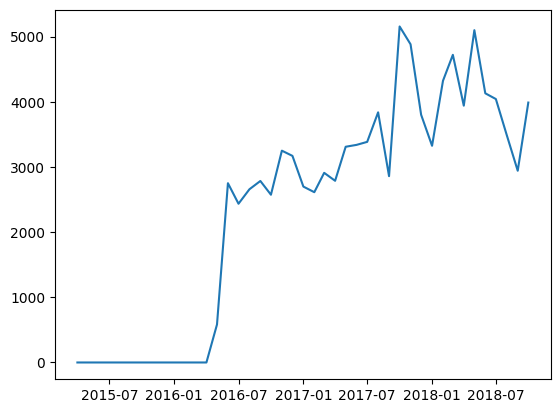

14944


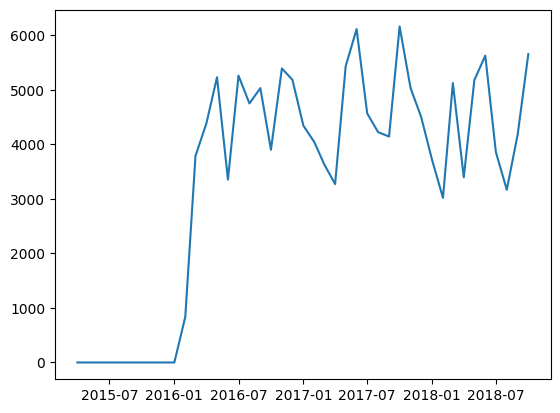

15131


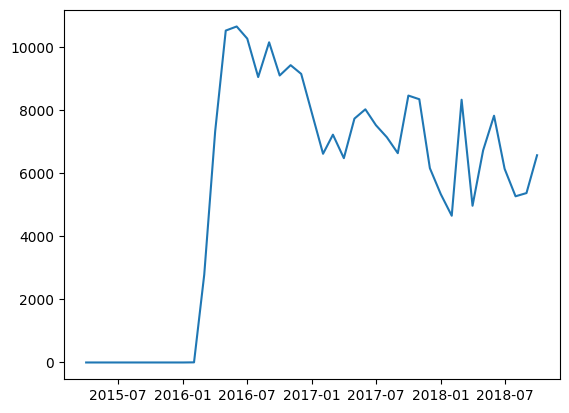

15148


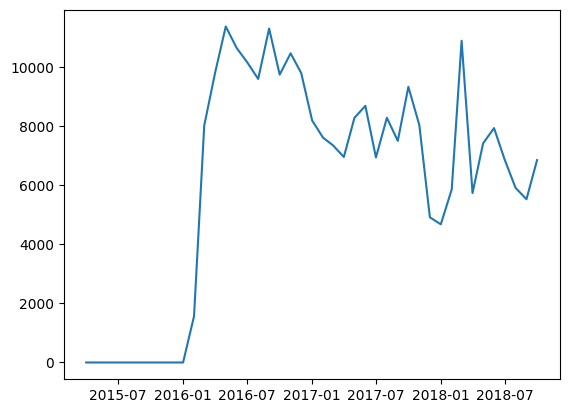

15505


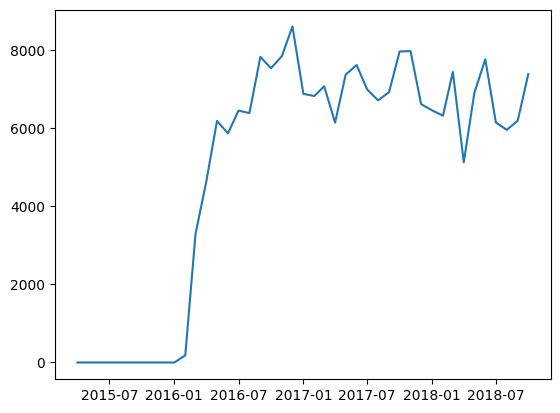

23240


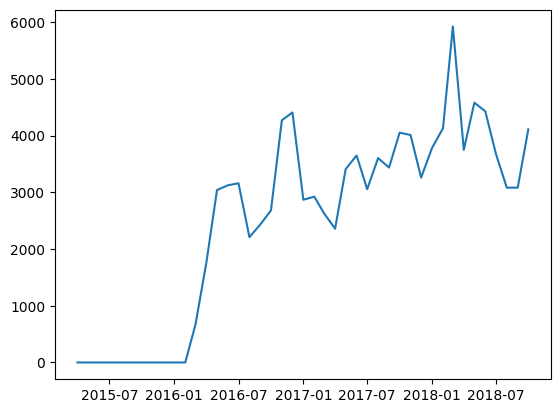

3351


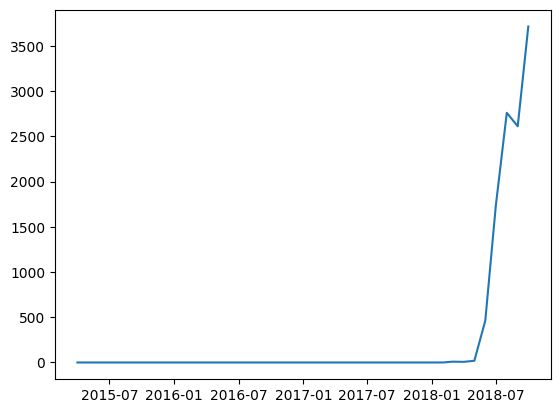

3438


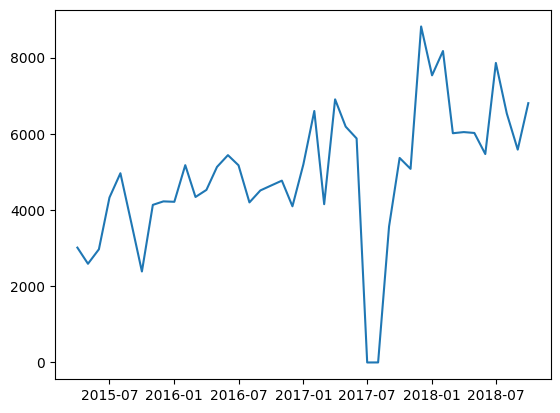

3442


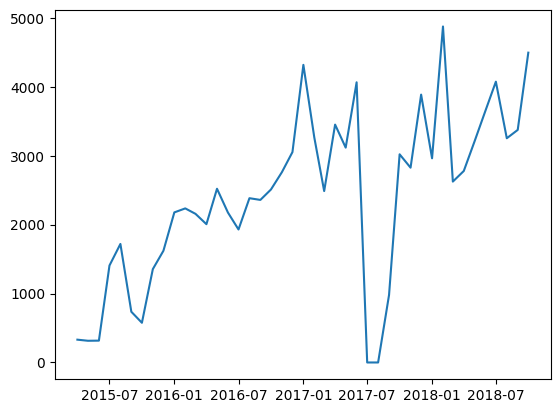

4022


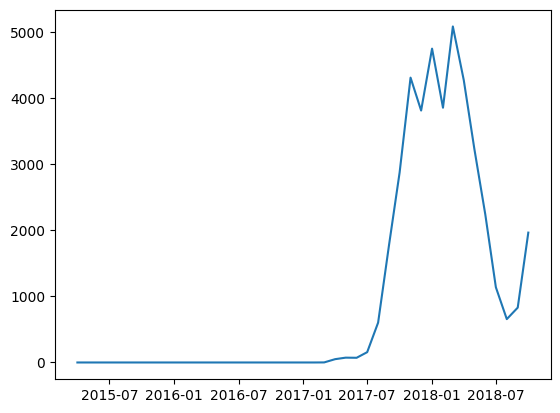

6070


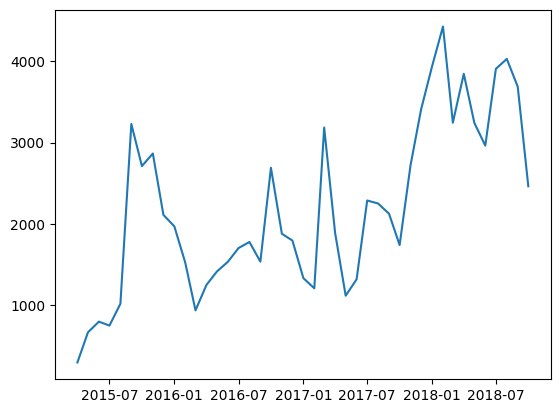

6189


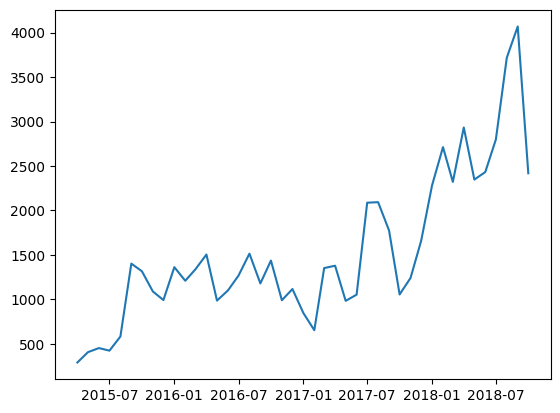

6240


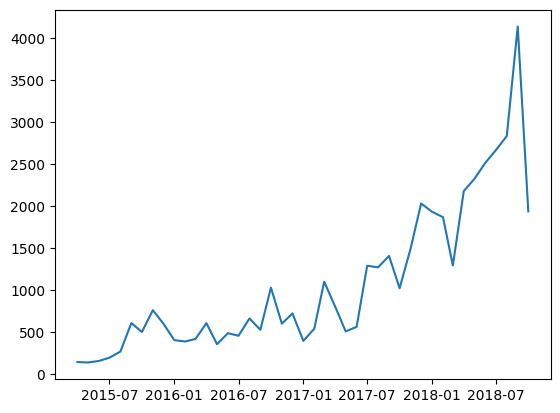

6252


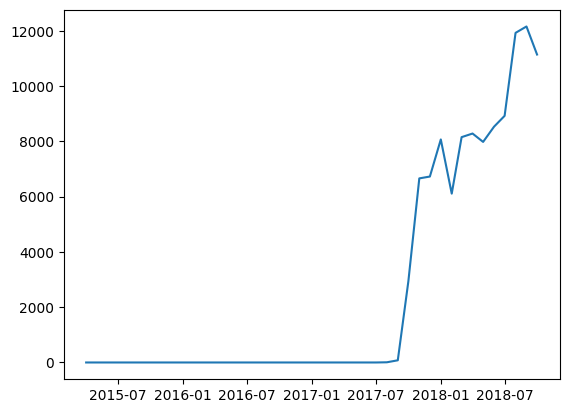

6699


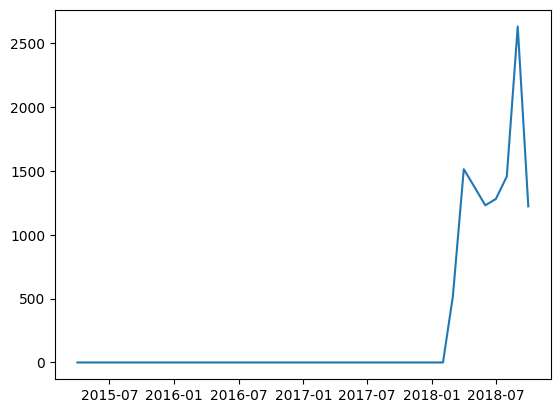

97946


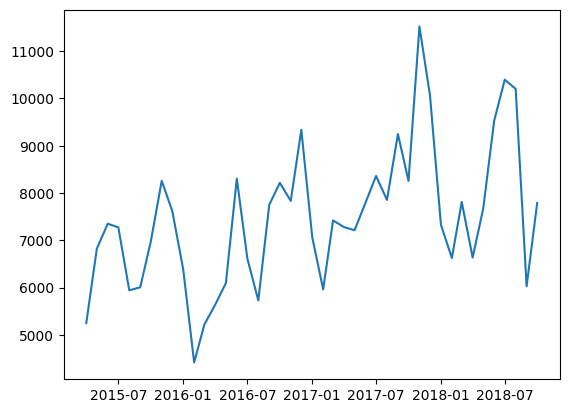

In [42]:
strong_mispreds = preds_merged.query("AbsDiff > 1000")['Article'].unique().tolist()

strong_mispreds = sales[sales["art"].isin(strong_mispreds)]
print(strong_mispreds.shape)
strong_mispreds['date'] = pd.to_datetime(strong_mispreds['year'].astype(str) + '-' + strong_mispreds['month'].astype(str) + '-01')
strong_mispreds = strong_mispreds.set_index('date')

for article in strong_mispreds['art'].unique().tolist():
  temp = strong_mispreds.query(f'art == "{article}"')
  temp = temp['units']
  print(article)
  plt.plot(temp)
  plt.show()

In [43]:
for article in strong_mispreds['art'].unique().tolist():
  print(article, sales[sales["art"] == f'{article}']['units'].std())

1408 1760.9564978656954
14944 2105.396942027666
15131 3648.737479126665
15148 3888.104331180423
15505 3102.6297339161715
23240 1698.4887934916828
3351 823.8944691800734
3438 1808.6302358445394
3442 1255.6964214206191
4022 1600.8875486809166
6070 1061.906290639465
6189 851.37108883084
6240 889.7359949121444
6252 4071.548016452324
6699 601.5713550677885
97946 1502.6549508918029


In [44]:
from scipy import stats

for article in strong_mispreds['art'].unique().tolist():
  temp = sales[sales["art"] == f'{article}']['units']
  # calculate the slope using linear regression
  slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(temp)), temp)

  # print the slope value
  print(article, slope)

1408 125.02038659015406
14944 117.91543340380552
15131 157.6883116883117
15148 158.04273633343402
15505 188.08728480821503
23240 114.89534883720921
3351 33.58894593778315
3438 73.36665659921475
3442 65.8462700090607
4022 83.66475385080038
6070 58.34415584415584
6189 54.26049531863485
6240 59.98520084566597
6252 259.6362126245847
6699 30.475536091815158
97946 61.14995469646632


In [45]:
#strong_mispreds

temp = strong_mispreds[["art","units"]]
temp_filtered = temp.query("units != 0.0")
temp_grouped = temp_filtered.groupby('art', as_index=False)['units'].median()
temp_grouped = temp_grouped.rename(columns={'art':'Article','units':'Prediction'})

In [46]:
strong_mispreds_old = preds_merged.query("AbsDiff > 1000")
strong_mispreds_new = preds_merged.query("AbsDiff > 1000")[['Article','Actual']]
strong_mispreds_new = pd.merge(temp_grouped, strong_mispreds_new, on='Article')
strong_mispreds_new['AbsDiff'] = abs(strong_mispreds_new['Actual'] - strong_mispreds_new['Prediction'])
strong_mispreds_new

,Article,Prediction,Actual,AbsDiff
0,1408,3316.5,3987.0,670.5
1,14944,4385.0,5654.0,1269.0
2,15131,7331.0,6571.0,760.0
3,15148,8017.0,6846.0,1171.0
4,15505,6825.0,7387.0,562.0
5,23240,3335.5,4111.0,775.5
6,3351,1100.5,3716.0,2615.5
7,3438,5105.5,6804.0,1698.5
8,3442,2521.0,4496.0,1975.0
9,4022,1872.0,1965.0,93.0


In [47]:
# Calculate WMAPE on strong_mispreds_new
print("WMAPE on new: ", sum(strong_mispreds_new['AbsDiff'])/sum(strong_mispreds_new['Actual']))
print("WMAPE on old: ", sum(strong_mispreds_old['AbsDiff'])/sum(strong_mispreds_old['Actual']))

print("Sum of the absdiffs new: ", sum(strong_mispreds_new['AbsDiff']))
print("Sum of the absdiffs old: ", sum(strong_mispreds_old['AbsDiff']))

WMAPE on new:  0.22995643534087434
WMAPE on old:  0.26878885152348925
Sum of the absdiffs new:  18052.5
Sum of the absdiffs old:  21101.0


### Prepare data for Han

In [10]:
sales

,art,units,month,year
0,106242,131.0,4,2015
1,106242,129.0,5,2015
2,106242,119.0,6,2015
3,106242,140.0,7,2015
4,106242,128.0,8,2015
...,...,...,...,...
18055,98150,3012.0,6,2018
18056,98150,2915.0,7,2018
18057,98150,2735.0,8,2018
18058,98150,2660.0,9,2018


In [11]:
# pivot the dataframe
sales_pivoted = sales.pivot(index=['year', 'art'], columns='month', values='units').reset_index()

# print the pivoted dataframe
sales_pivoted


month,year,art,1,10,11,12,2,3,4,5,6,7,8,9
0,2015,106242,NaN,202.0,204.0,201.0,NaN,NaN,131.0,129.0,119.0,140.0,128.0,133.0
1,2015,106259,NaN,993.0,1384.0,1192.0,NaN,NaN,778.0,1062.0,1126.0,1202.0,1074.0,1167.0
2,2015,106310,NaN,1647.0,1783.0,1362.0,NaN,NaN,869.0,1360.0,1406.0,1586.0,1854.0,2056.0
3,2015,106497,NaN,2523.0,3778.0,2905.0,NaN,NaN,3651.0,3585.0,3847.0,3608.0,4778.0,2959.0
4,2015,106650,NaN,1228.0,1503.0,968.0,NaN,NaN,655.0,676.0,952.0,987.0,1443.0,1683.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,2018,98031,519.0,285.0,NaN,NaN,439.0,401.0,374.0,393.0,532.0,387.0,386.0,296.0
1676,2018,98048,736.0,615.0,NaN,NaN,673.0,997.0,755.0,896.0,945.0,919.0,877.0,697.0
1677,2018,98065,2119.0,1774.0,NaN,NaN,2118.0,2280.0,2028.0,2061.0,2455.0,2307.0,2627.0,2354.0
1678,2018,98099,2349.0,2845.0,NaN,NaN,2210.0,2534.0,2203.0,2571.0,3072.0,2810.0,2649.0,2732.0


In [12]:
temp = sales_pivoted[['art','year','7','8','9','10']]
temp['AvgLast3Months'] = temp[['7', '8', '9']].apply(lambda x: x.mean(), axis=1)

temp = temp[['art','year','7','8','9','AvgLast3Months','10']]
temp = temp.rename(columns={'art':'ARTICLE_ID','year':'YEAR'})
final = temp[temp['YEAR'] == '2018']
final

month,ARTICLE_ID,YEAR,7,8,9,AvgLast3Months,10
1260,106242,2018,410.0,489.0,520.0,473.000000,482.0
1261,106259,2018,620.0,675.0,593.0,629.333333,610.0
1262,106310,2018,935.0,898.0,501.0,778.000000,368.0
1263,106497,2018,1312.0,1586.0,1634.0,1510.666667,1278.0
1264,106650,2018,527.0,640.0,682.0,616.333333,508.0
...,...,...,...,...,...,...,...
1675,98031,2018,387.0,386.0,296.0,356.333333,285.0
1676,98048,2018,919.0,877.0,697.0,831.000000,615.0
1677,98065,2018,2307.0,2627.0,2354.0,2429.333333,1774.0
1678,98099,2018,2810.0,2649.0,2732.0,2730.333333,2845.0


In [16]:
final.to_csv("last_3_mo_articles_sold.csv", index=False)

## DELETE LATER - SANITY CHECK THAT PIVOT WORKED CORRECTLY

In [36]:
cols = sales_pivoted.columns.tolist()
cols.remove('year')
cols.remove('art')

In [37]:
cols

['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']

In [38]:
vals = []

for i in cols:
  
  print(i)
  vals.append(sales_pivoted[i].count())

sum(vals)

1
10
11
12
2
3
4
5
6
7
8
9


18060

In [19]:
sales_pivoted.shape


(1680, 14)

In [17]:
(1680*14), (18060*4)

(23520, 72240)

## XGBoost on difficult articles

In [48]:
articles = strong_mispreds['art'].unique().tolist()

df = sales[sales['art'].isin(articles)]
df

,art,units,month,year
2838,1408,0.0,4,2015
2839,1408,0.0,5,2015
2840,1408,0.0,6,2015
2841,1408,0.0,7,2015
2842,1408,0.0,8,2015
...,...,...,...,...
17711,97946,9528.0,6,2018
17712,97946,10397.0,7,2018
17713,97946,10203.0,8,2018
17714,97946,6027.0,9,2018


In [49]:
df['art'] = df['art'].astype('category')

# Set features and target data
X, y = df[["art","month","year"]], df["units"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Store data as DMatrix
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Define hyperparameters
params = {"objective": "reg:squarederror", "max_depth":3, "tree_method": "gpu_hist"}

# Fit model
n = 1000
model = xgb.train(
   params=params,
   dtrain=dtrain,
   num_boost_round=n,
)

# Get predictions
preds = model.predict(dtest)
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the new base model: {rmse:.3f}")

# Combine the ndarray and Series into a pandas dataframe
results = pd.DataFrame({'Article':X_test['art'], 'Month':X_test['month'], 'Year':X_test['year'], 'Predictions': preds, 'Actuals': y_test, 'AbsoluteDifference':abs(preds-y_test)})

wmape = sum(abs(preds-y_test))/sum(y_test)
print("WMAPE: ", wmape)

RMSE of the new base model: 1286.054
WMAPE:  0.33091070062531336


In [5]:
# final_sales = pd.read_csv("final_sales.csv", 
#                     usecols=["ARTICLE_ID","STORE_ID","DATE","UNITS"], 
#                     parse_dates=["DATE"], 
#                     dtype={"ARTICLE_ID":"string",
#                            "STORE_ID":"category",
#                            "UNITS":np.float64},
#                     low_memory=False)
# final_sales.head(5)

,STORE_ID,DATE,ARTICLE_ID,UNITS
0,27,2018-07-01,3724,1.0
1,27,2018-07-05,17902,2.0
2,27,2018-07-02,7099718,1.0
3,27,2018-07-05,4012,4.0
4,27,2018-07-05,122613,1.0


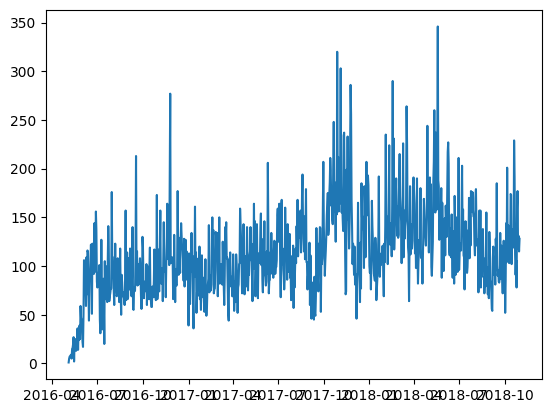

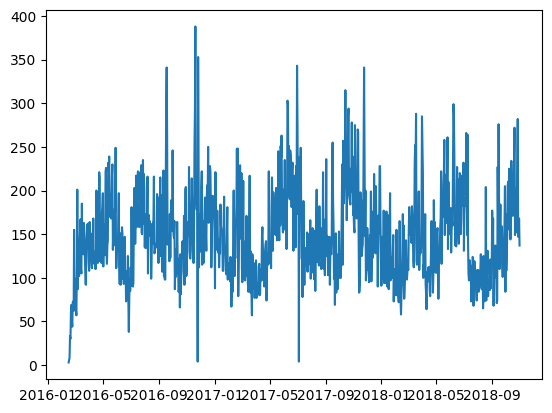

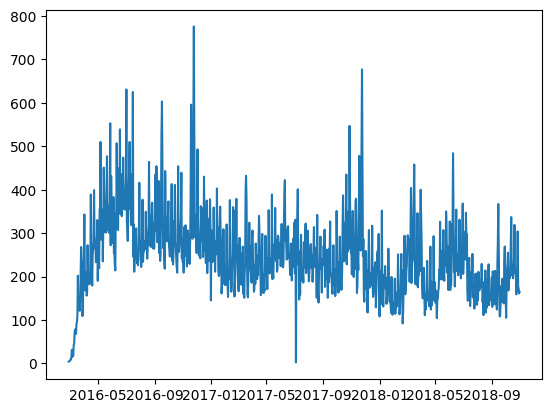

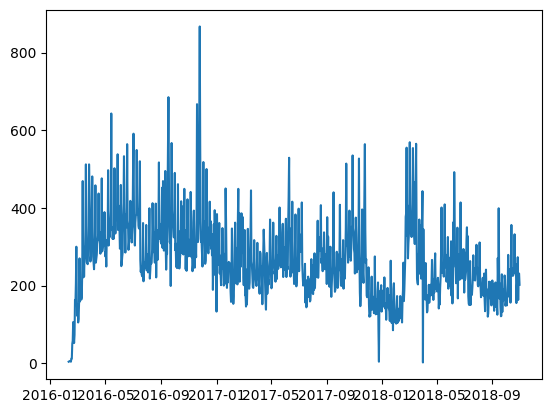

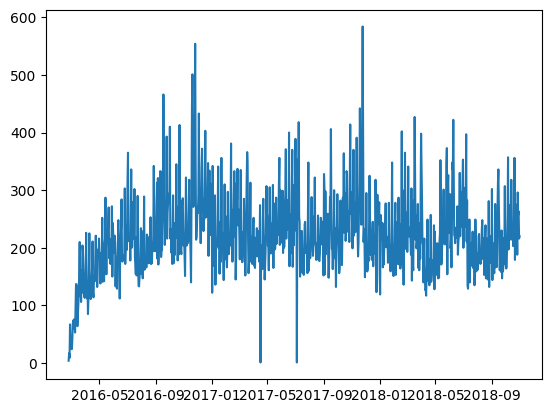

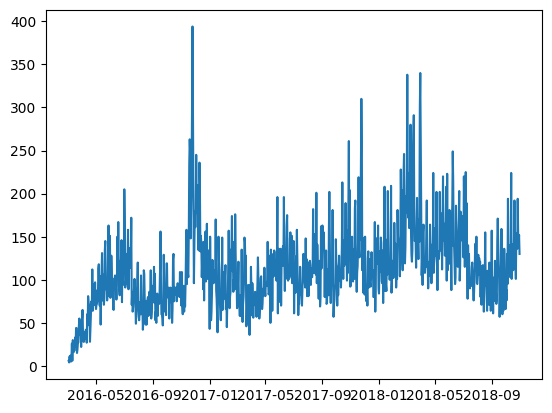

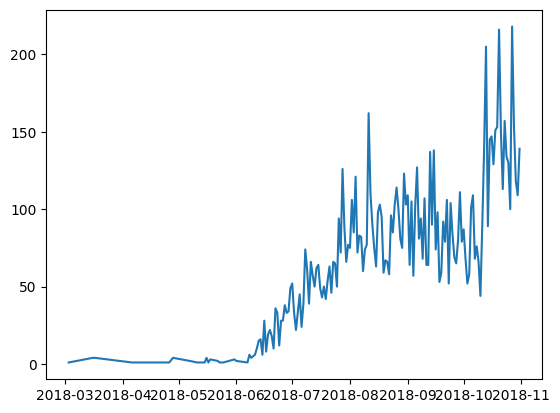

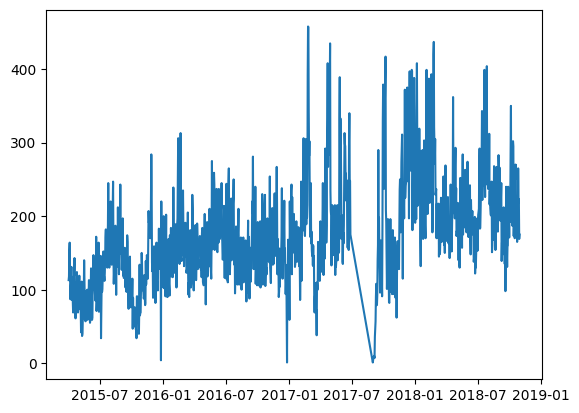

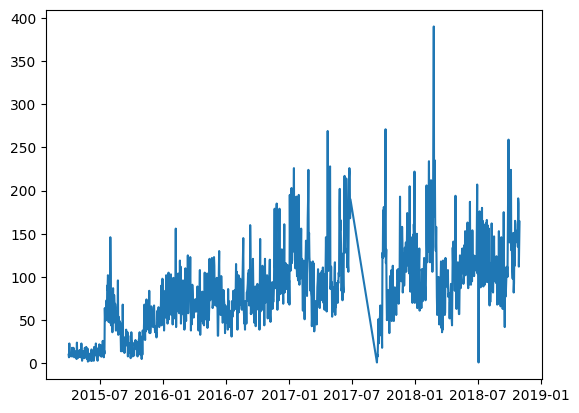

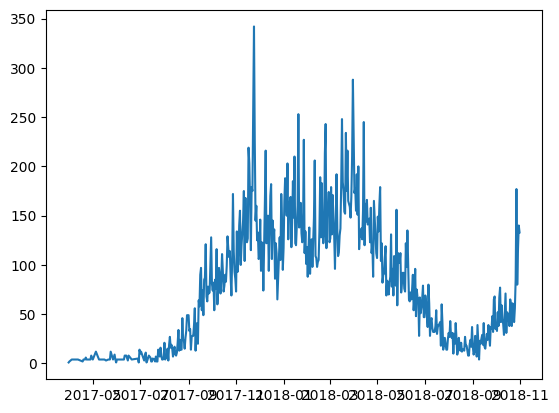

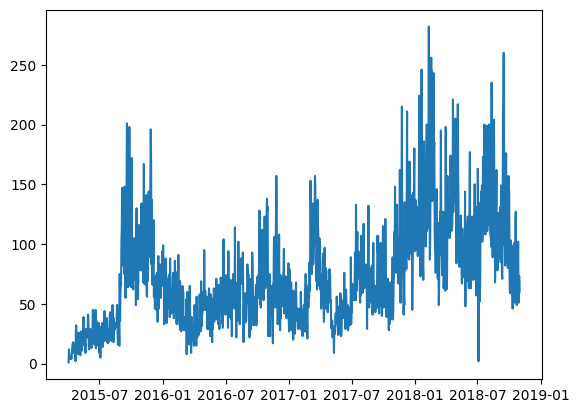

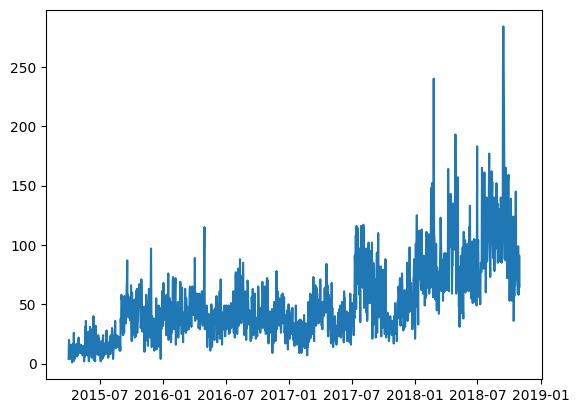

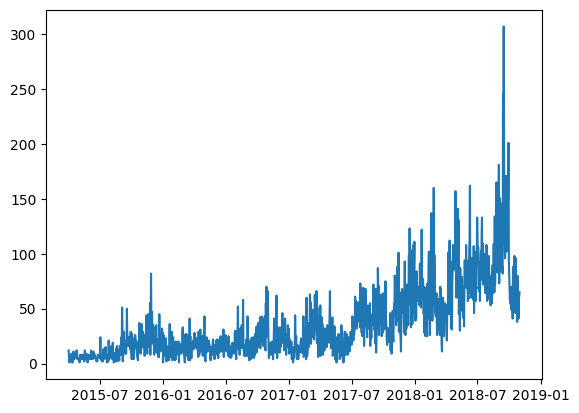

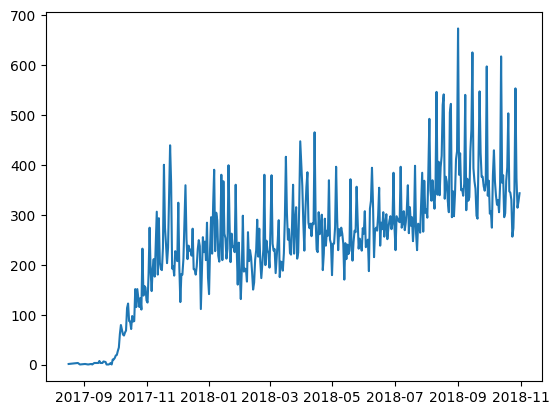

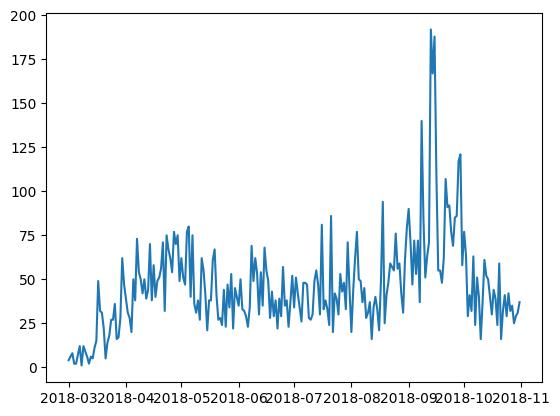

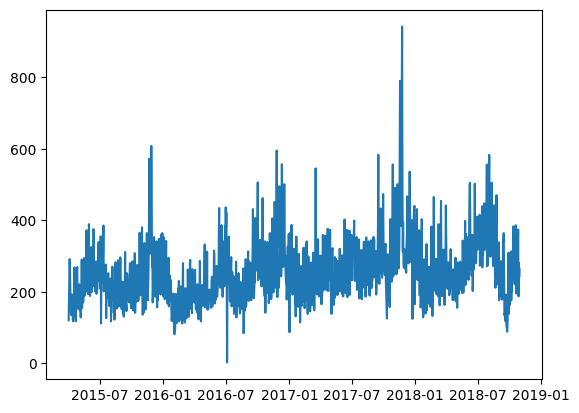

In [70]:
for art in articles:
  temp = final_sales.query(f'ARTICLE_ID == "{art}"')
  temp = temp[["DATE","UNITS"]]
  temp_plot = temp.groupby(["DATE"])["UNITS"].sum()
  plt.plot(temp_plot)
  plt.show()

### TODO: DELETE
Also consider using running total? 

In [ ]:
results.query("Year == '2018' & Month == '10'")

,Article,Month,Year,Predictions,Actuals,AbsoluteDifference
7868,23240,10,2018,4625.672852,4111.0,514.672852
14705,6699,10,2018,412.010742,1222.0,809.989258
4471,14944,10,2018,3980.090820,5654.0,1673.909180
5546,15505,10,2018,7450.246582,7387.0,63.246582
10190,3442,10,2018,3181.548340,4496.0,1314.451660


What happens if I leave Oct 2018 out for validation and make Sept 2018 the test set? 

Results in the experiment below suggest that this is not a good approach.

In [ ]:
df['art'] = df['art'].astype('category')
validation_data = df.query("year == '2018' & month == '10'")
test_data = df.query("year == '2018' & month == '9'")
train_data = df.query("year == '2018' & (month != '9' & month != '10')")

# Set features and target data
X_train, y_train = train_data[["art","month","year"]], train_data["units"]
X_test, y_test = test_data[["art","month","year"]], test_data["units"]

# Store data as DMatrix
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Define hyperparameters
params = {"objective": "reg:squarederror", "max_depth":3, "tree_method": "gpu_hist"}

# Fit model
n = 10000
model = xgb.train(
   params=params,
   dtrain=dtrain,
   num_boost_round=n,
)

# Get predictions
preds = model.predict(dtest)
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the new base model: {rmse:.3f}")

# Combine the ndarray and Series into a pandas dataframe
results = pd.DataFrame({'Article':X_test['art'], 'Month':X_test['month'], 'Year':X_test['year'], 'Predictions': preds, 'Actuals': y_test, 'AbsoluteDifference':abs(preds-y_test)})

wmape = sum(abs(preds-y_test))/sum(y_test)
print("WMAPE: ", wmape)

RMSE of the new base model: 2585.940
WMAPE:  0.46994621150937005


In [ ]:
# Importing date module from datetime
from datetime import date
 
# Taking the parameter from the calling function
def convert_date_to_excel_ordinal(day, month, year):
 
    # Specifying offset value i.e.,
    # the date value for the date of 1900-01-00
    offset = 693594
    current = date(year, month, day)
 
    # Calling the toordinal() function to get
    # the excel serial date number in the form
    # of date values
    n = current.toordinal()
    return (n - offset)
 
# Calculating the excel serial date number
# for the date "02-02-2021" by calling the
# user defined function convert_date_to_excel_ordinal()
print(convert_date_to_excel_ordinal(30, 11, 2018))

43434


In [ ]:
# running tot pred for oct_2018
oct = (43403*246.96)-(1.0399e7)
# running tot sept_2018
sept = 313327

oct-sept

6477.88000000082